<a href="https://colab.research.google.com/github/Gaurav-phatkare/BERT_Model-NLP/blob/main/BERT_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT - Bidirectional Encoder Representations from Transformers
---
As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).


further explaination from [HuggingFace.co](https://huggingface.co/blog/bert-101?text=The+goal+of+life+is+%5BMASK%5D.)

##Skimlit Medical Abstract Classifier Using BERT Model Approach

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9bb487ea-bd60-837c-55bd-f8fd9f76c857)


In [2]:
# !pip install tensorflow==2.9.1
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
# !pip install tensorflow_text

In [4]:
# import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

###Get Data
[Dataset Link](https://github.com/Franck-Dernoncourt/pubmed-rct)


In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 13.22 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [71]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [74]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT/'

In [75]:
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT/train.txt']

###Preprocess the data

In [76]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [77]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n']

In [80]:
len(train_lines)

210040

In [81]:
def preprocess_text_with_line_number(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
       abstract_lines += line

  return abstract_samples

In [82]:
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [83]:
train_samples[:5], len(train_samples)

([{'target': 'OBJECTIVE',
   'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
   'line_number': 0,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
   'line_number': 1,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 2,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
   'line_number': 3,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'secondary outcome measures 

In [84]:
import pandas as pd
import numpy as np

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [85]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [86]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

###Convert to list

In [87]:
train_sentances = train_df['text'].tolist()
val_sentances = val_df['text'].tolist()
test_sentances = test_df['text'].tolist()

len(train_sentances), len(val_sentances), len(test_sentances)

(180040, 30212, 30135)

### Make Numeric Labels

In [88]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [89]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [90]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [91]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [92]:
# function for accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def calculate_results(y_true, y_pred):
  """
  calculate model acuracy, precision, recall and f1 score of a binary classification model
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculat model precision, recall and f1-score using weigthed average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average = 'weighted' )

  model_results = {

                   'accuracy' :model_accuracy,
                   'precision':model_precision,
                   'recall' : model_recall,
                   'f1' : model_f1
  }
  return model_results

In [93]:
from tensorflow.keras.layers import TextVectorization, Embedding

sent_len = [len(i.split()) for i in train_sentances]

In [94]:
sent_len[:5]

[49, 27, 15, 14, 35]

In [95]:
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338435903132638

(array([1.6499e+04, 5.6664e+04, 5.2682e+04, 2.9051e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

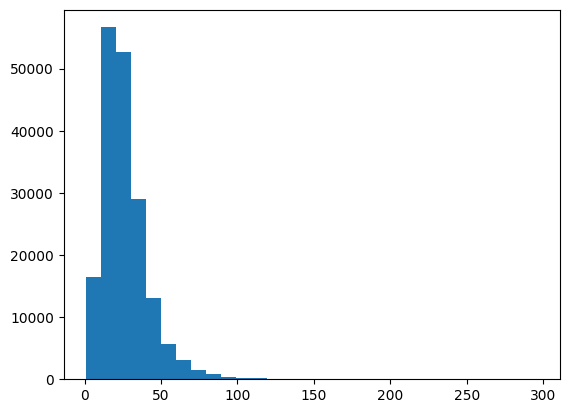

In [96]:
import matplotlib.pyplot as plt
plt.hist(sent_len, bins = 30)

In [97]:
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [98]:
max_tokens = 68000 #given in paper

In [99]:
text_vectorizer  = TextVectorization(max_tokens = max_tokens,
                                     output_sequence_length = output_seq_len)

In [100]:
# adapt text vectorizer to training sentance
text_vectorizer.adapt(train_sentances)

In [101]:
# words in training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [102]:
print(len(rct_20k_text_vocab))
print(rct_20k_text_vocab[:5])
print(rct_20k_text_vocab[-5:])

68000
['', '[UNK]', 'the', 'and', 'of']
['httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee', 'httpsregisterclinicaltrialsgov', 'httpsmartmicrosurgerycom', 'httpseudractemaeuropaeuindexhtml', 'httpseudractemaeuropaeu']


In [103]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 256,
    name = 'token_embedding'
)

In [104]:

# Test out text vectorizer and embedding on random sentances

import random
target_sentance = random.choice(train_sentances)

print(f'Target sentance:\n{target_sentance}\n\n')
print(f'Vectorized target sentance:\n{text_vectorizer([target_sentance])}\n\n')
print(f'shape of vectorized sentance:{text_vectorizer([target_sentance]).shape}\n\n')
print(f'embedded target sentance:\n{embedding(text_vectorizer([target_sentance]))}\n\n')
print(f'shape of embedded sentance:{embedding(text_vectorizer([target_sentance])).shape}')

Target sentance:
brief inhalation of coarse pm from a rural location did not acutely impair several facets of hdl functionality .


Vectorized target sentance:
[[ 1047  2549     4 26558  3322    27     8  1834  2632   117    31  5951
   7719   965 26122     4  1954  9011     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


shape of vectorized sentance:(1, 55)


embedded target sentance:
[[[-0.04071499  0.03173764 -0.00385082 ... -0.02648994  0.03369473
    0.01459702]
  [-0.0333757  -0.02497201 -0.03556053 ...  0.01233252 -0.00692268
   -0.04516242]
  [ 0.01007835 -0.02390668  0.0325657  ... -0.01218325 -0.0351359
   -0.01064372]
  ...
  [ 0.03085936  0.04234285 -0.03872831 ... -0.0316386  -0.03496332
   -0.04519011]
  [ 0.03085936  0.04234285 -0.03872831 ... -0.0316386  -0.03496332
   -0.04519011]
  [ 0.03085

###Character Level Encoding

In [105]:
def split_character(text):
  return ' '.join(list(text))


In [106]:
train_chars = [split_character(sentences) for sentences in train_sentances]
val_chars = [split_character(sentences) for sentences in val_sentances]
test_chars = [split_character(sentences) for sentences in test_sentances]

In [ ]:
train_chars

In [108]:
char_lens = [len(sentance) for sentance in train_sentances]
mean_char_len = np.mean(char_lens)
mean_char_len

152.006276383026

In [109]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

296

In [110]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [111]:
# create char- level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = None,
                                    name = 'char_vectorizer')

In [112]:
# Adapt character char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [113]:
char_vocab = char_vectorizer.get_vocabulary()

In [114]:
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(69, ['', '[UNK]', 'e', 't', 'i'], ['{', '@', '|', '"', '\\'])

###Character Level Embedding layer

In [115]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 56,
    name = 'char_embed'
)

In [116]:
# Test our character embedding layer

random_sent = random.choice(train_chars)


print(f"Characterized sentance : \n{random_sent}\n")
print(f"Len of sentance:{len(random_sent.split())}\n")
print(f"Embedded sentance : \n{char_vectorizer(random_sent)}\n")
print(f'len of embedded sentance(Preset): {len(char_vectorizer(random_sent))}\n')

print(f"embedded char sentance:\n{char_embedding(char_vectorizer(random_sent))}\n")
print(f"shape of embedded char sentance:{char_embedding(char_vectorizer(random_sent)).shape}")

Characterized sentance : 
r e c e n t l y   ,   t h e r e   h a v e   b e e n   i n v e s t i g a t i o n s   t h a t   h a v e   t a r g e t e d   i m p r o v i n g   t h e   r e l a t i v e l y   p o o r   v a l i d i t y   a n d   r e l i a b i l i t y   o f   a t t e n t i o n a l   b i a s   m e a s u r e s   .

Len of sentance:126

Embedded sentance : 
[ 8  2 11  2  6  3 12 19 24  3 13  2  8  2 13  5 22  2 23  2  2  6  4  6
 22  2  9  3  4 18  5  3  4  7  6  9  3 13  5  3 13  5 22  2  3  5  8 18
  2  3  2 10  4 15 14  8  7 22  4  6 18  3 13  2  8  2 12  5  3  4 22  2
 12 19 14  7  7  8 22  5 12  4 10  4  3 19  5  6 10  8  2 12  4  5 23  4
 12  4  3 19  7 17  5  3  3  2  6  3  4  7  6  5 12 23  4  5  9 15  2  5
  9 16  8  2  9 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Positional Embedding layer

In [117]:
import tensorflow as tf
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)


In [118]:
train_line_number_one_hot[:5],

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,)

In [119]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5],

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,)

###Creating tribrid inputs
---
Prefetched Dataset

In [120]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentances, train_chars))

train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentances, val_chars))

val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [122]:
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                        test_total_line_number_one_hot,
                                                        test_sentances,
                                                        test_chars))

test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Building BERT Models

In [123]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [124]:
preprocess_layer = hub.KerasLayer(preprocess, name = 'bert_input_preprocess')
bert_layer = hub.KerasLayer(bert, name = 'bert_layer')

###Build a model

In [125]:
from tensorflow import keras
from tensorflow.keras import layers

In [126]:
#1. Token Inputs
token_inputs = layers.Input(shape=[], dtype = tf.string, name='token_inputs', ragged = False)
bert_input = preprocess_layer(token_inputs)
bert_outputs = bert_layer(bert_input, training = False)
sequence_output = bert_outputs['pooled_output']
token_outputs = layers.Dense(128, activation = 'relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)


# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer according to the paper
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)


# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])


# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)



In [127]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 bert_input_preprocess (Ker  {'input_type_ids': (None,    0         ['token_inputs[0][0]']        
 asLayer)                    128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                    

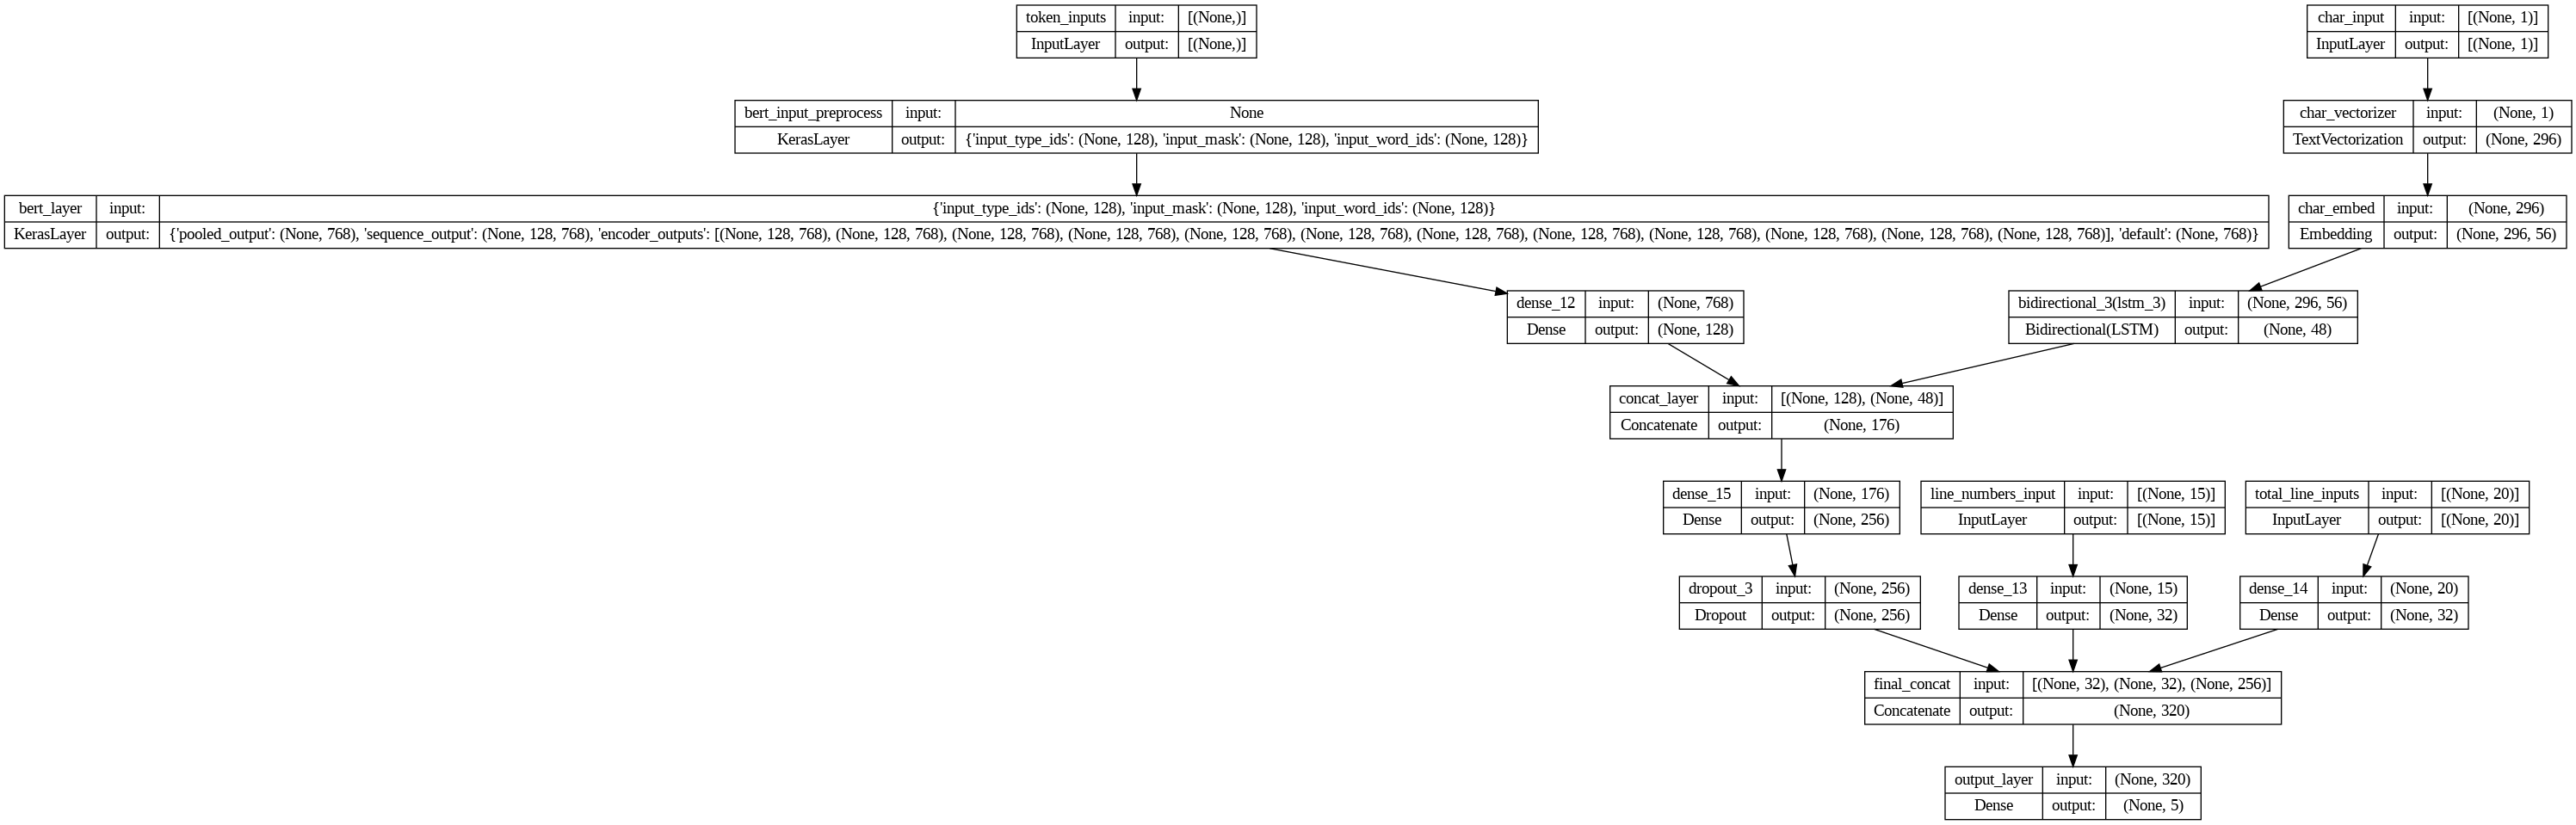

In [128]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

###Compile the model

In [129]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

In [130]:
model_history = model.fit(
    train_tribrid_dataset,
    epochs = 6,
    steps_per_epoch = int(0.1 * len(train_tribrid_dataset)),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.1 * len(val_tribrid_dataset))
)

Epoch 1/6
562/562 [==============================] - 263s 445ms/step - loss: 0.9803 - accuracy: 0.8168 - val_loss: 0.8871 - val_accuracy: 0.8664
Epoch 2/6
562/562 [==============================] - 240s 426ms/step - loss: 0.8906 - accuracy: 0.8706 - val_loss: 0.8619 - val_accuracy: 0.8797
Epoch 3/6
562/562 [==============================] - 247s 440ms/step - loss: 0.8771 - accuracy: 0.8776 - val_loss: 0.8557 - val_accuracy: 0.8816
Epoch 4/6
562/562 [==============================] - 239s 425ms/step - loss: 0.8728 - accuracy: 0.8794 - val_loss: 0.8495 - val_accuracy: 0.8866
Epoch 5/6
562/562 [==============================] - 240s 427ms/step - loss: 0.8676 - accuracy: 0.8823 - val_loss: 0.8508 - val_accuracy: 0.8873
Epoch 6/6
562/562 [==============================] - 248s 441ms/step - loss: 0.8702 - accuracy: 0.8786 - val_loss: 0.8413 - val_accuracy: 0.8913


In [131]:
model.evaluate(val_tribrid_dataset)

945/945 [==============================] - 335s 354ms/step - loss: 0.8399 - accuracy: 0.8940


[0.8399335741996765, 0.8940487504005432]